# Práctica: Factorización LU y Coste Computacional

## Objetivo

El objetivo de esta práctica es comprender el proceso de factorización LU y cómo escala computacionalmente con el tamaño de la matriz. 

## Parte 1: Introducción teórica

La factorización LU permite descomponer una matriz cuadrada $A$ como el producto de una matriz triangular inferior $L$ y una matriz triangular superior $U$:

$$A = LU$$

Esta técnica es útil para resolver sistemas de ecuaciones lineales $Ax = b$ de forma eficiente. En lugar de resolver directamente el sistema, se resuelven dos sistemas triangulares:

1. $Ly = b$ (por sustitución hacia adelante).
2. $Ux = y$ (por sustitución hacia atrás).

## Parte 2: Preparación del entorno 

In [30]:
import numpy as np
import scipy.linalg
import time
import matplotlib.pyplot as plt

## Parte 3: Factorización LU en un problema físico simplificado 

En lugar de usar matrices aleatorias, consideramos un problema de interés físico: la discretización 1D de la ecuación de Poisson en un dominio $[0,1]$, que aparece en muchos contextos de ingeniería, incluyendo el modelado de potencial eléctrico o distribución de presión en fluidos incompresibles.

### Derivación de la matriz de Poisson 1D

La ecuación de Poisson en una dimensión es:

$$
-\frac{d^2u}{dx^2} = f(x), \quad x \in (0,1), \quad u(0)=u(1)=1
$$

Si discretizamos el intervalo $[0,1]$ en $n+2$ puntos con paso $h=1/(n+1)$, y aplicamos diferencias finitas centradas:

$$
-\frac{u_{i-1} - 2u_i + u_{i+1}}{h^2} = f_i
$$

Para imponer fuertemente las condiciones de contorno $u(0) = u(1) = 0$, modificamos la matriz para que las filas correspondientes sean de la forma:

- Primera fila: $[1, 0, 0, ..., 0]$
- Última fila: $[0, ..., 0, 1]$

In [31]:
def matriz_poisson_1d(n):
    A = 2 * np.eye(n)
    for i in range(1, n - 1):
        A[i, i + 1] = A[i + 1, i] = -1
    A[0, :] = 0
    A[-1, :] = 0
    A[0, 0] = 1
    A[-1, -1] = 1
    return A

n = 5
A = matriz_poisson_1d(n)
P, L, U = scipy.linalg.lu(A)

print("Matriz A (Poisson 1D con CC):")
print(A)
print("\nMatriz L:")
print(L)
print("\nMatriz U:")
print(U)
print("\nVerificación: LU ≈ PA")
print(np.allclose(L @ U, P @ A))

Matriz A (Poisson 1D con CC):
[[ 1.  0.  0.  0.  0.]
 [ 0.  2. -1.  0.  0.]
 [ 0. -1.  2. -1.  0.]
 [ 0.  0. -1.  2. -1.]
 [ 0.  0.  0.  0.  1.]]

Matriz L:
[[ 1.          0.          0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.        ]
 [ 0.         -0.5         1.          0.          0.        ]
 [ 0.          0.         -0.66666667  1.          0.        ]
 [ 0.          0.          0.          0.          1.        ]]

Matriz U:
[[ 1.          0.          0.          0.          0.        ]
 [ 0.          2.         -1.          0.          0.        ]
 [ 0.          0.          1.5        -1.          0.        ]
 [ 0.          0.          0.          1.33333333 -1.        ]
 [ 0.          0.          0.          0.          1.        ]]

Verificación: LU ≈ PA
True


## Parte 4: Medición del tiempo de factorización 

In [32]:
def medir_tiempo_factorizacion(n):
    A = matriz_poisson_1d(n)
    inicio = time.time()
    scipy.linalg.lu(A)
    fin = time.time()
    return fin - inicio

## Parte 5: Análisis del coste computacional 

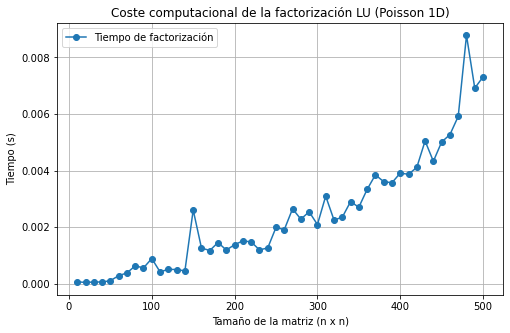

In [33]:
sizes = np.arange(10, 501, 10)
tiempos = [medir_tiempo_factorizacion(n) for n in sizes]

plt.figure(figsize=(8, 5))
plt.plot(sizes, tiempos, marker='o', linestyle='-', label='Tiempo de factorización')
plt.xlabel('Tamaño de la matriz (n x n)')
plt.ylabel('Tiempo (s)')
plt.title('Coste computacional de la factorización LU (Poisson 1D)')
plt.grid(True)
plt.legend()
plt.show()

Aunque esta matriz es más estructurada que una aleatoria, la complejidad teórica del método LU sigue siendo cúbica. En la práctica, existen métodos más eficientes para matrices tridiagonales (como Thomas), pero aquí usamos LU para estudiar su coste general.

Además, **la matriz P** aparece cuando se aplica la factorización LU con pivoteo parcial. En esta variante, se intercambian filas de la matriz $A$ para mejorar la estabilidad numérica. La matriz $P$ es una **matriz de permutación** que refleja estos intercambios de filas. Así, se obtiene la descomposición:

$$
PA = LU
$$

## Parte 6: Ajuste de curva teórica

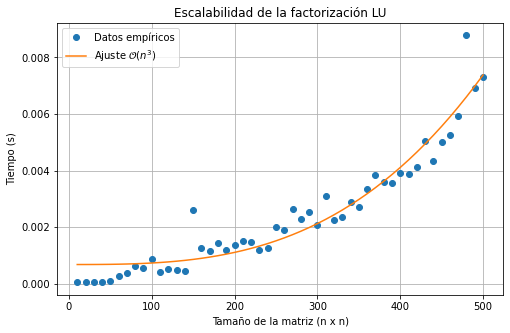

In [34]:
from numpy.polynomial.polynomial import Polynomial

x3 = sizes**3
coef = np.polyfit(x3, tiempos, 1)
ajuste = coef[0] * x3 + coef[1]

plt.figure(figsize=(8, 5))
plt.plot(sizes, tiempos, 'o', label='Datos empíricos')
plt.plot(sizes, ajuste, '-', label=f'Ajuste $\mathcal{{O}}(n^3)$')
plt.xlabel('Tamaño de la matriz (n x n)')
plt.ylabel('Tiempo (s)')
plt.title('Escalabilidad de la factorización LU')
plt.legend()
plt.grid(True)
plt.show()

### Ejercicio a completar ✍️

Usando la descomposición LU de la matriz de Poisson, mide el tiempo que tarda en **resolver el sistema $Ax = b$** para distintos tamaños de $n$:

1. Considera un vector $b$ con todas sus entradas iguales a 1.
2. Guarda el tiempo que tarda en resolver el sistema usando `L` y `U` (sustitución hacia adelante y atrás).
3. Grafica los tiempos y compáralos con el tiempo de factorización.

**Pista**: puedes usar `scipy.linalg.solve_triangular`.

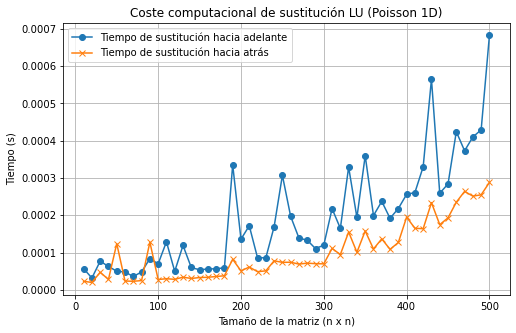

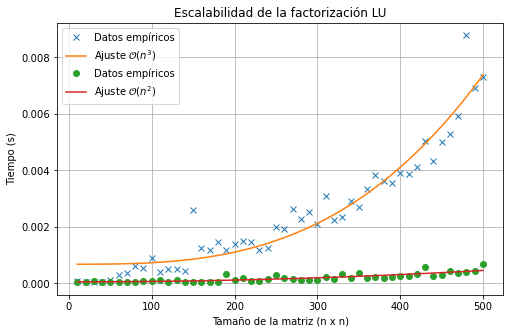

In [35]:
# Función para medir el tiempo de sustitución hacia adelante y hacia atrás
def medir_tiempos_sustitucion(n):
    A = matriz_poisson_1d(n)
    b = np.ones(n)  # Vector b con todas las entradas iguales a 1
    P, L, U = scipy.linalg.lu(A)
    
    # Medir tiempo de sustitución hacia adelante (Ly = Pb)
    inicio_sustitucion_adelante = time.time()
    y = scipy.linalg.solve_triangular(L, np.dot(P, b), lower=True)
    fin_sustitucion_adelante = time.time()
    tiempo_sustitucion_adelante = fin_sustitucion_adelante - inicio_sustitucion_adelante
    
    # Medir tiempo de sustitución hacia atrás (Ux = y)
    inicio_sustitucion_atras = time.time()
    x = scipy.linalg.solve_triangular(U, y)
    fin_sustitucion_atras = time.time()
    tiempo_sustitucion_atras = fin_sustitucion_atras - inicio_sustitucion_atras
    
    return tiempo_sustitucion_adelante, tiempo_sustitucion_atras

# Medir el tiempo para sustitución hacia adelante y hacia atrás para diferentes tamaños de n
sizes = np.arange(10, 501, 10)
tiempos_sustitucion_adelante = []
tiempos_sustitucion_atras = []

for n in sizes:
    tiempo_sustitucion_adelante, tiempo_sustitucion_atras = medir_tiempos_sustitucion(n)
    tiempos_sustitucion_adelante.append(tiempo_sustitucion_adelante)
    tiempos_sustitucion_atras.append(tiempo_sustitucion_atras)


# Graficar los resultados
plt.figure(figsize=(8, 5))
plt.plot(sizes, tiempos_sustitucion_adelante, marker='o', linestyle='-', label='Tiempo de sustitución hacia adelante')
plt.plot(sizes, tiempos_sustitucion_atras, marker='x', linestyle='-', label='Tiempo de sustitución hacia atrás')
plt.xlabel('Tamaño de la matriz (n x n)')
plt.ylabel('Tiempo (s)')
plt.title('Coste computacional de sustitución LU (Poisson 1D)')
plt.grid(True)
plt.legend()
plt.show()

# Escalado de coste computational
x2 = sizes**2
coef = np.polyfit(x2, tiempos_sustitucion_adelante, 1)
ajuste_sust = coef[0] * x2 + coef[1]

plt.figure(figsize=(8, 5))
plt.plot(sizes, tiempos, 'x', label='Datos empíricos')
plt.plot(sizes, ajuste, '-', label=f'Ajuste $\mathcal{{O}}(n^3)$')
plt.plot(sizes, tiempos_sustitucion_adelante, 'o', label='Datos empíricos')
plt.plot(sizes, ajuste_sust, '-', label=f'Ajuste $\mathcal{{O}}(n^2)$')
plt.xlabel('Tamaño de la matriz (n x n)')
plt.ylabel('Tiempo (s)')
plt.title('Escalabilidad de la factorización LU')
plt.legend()
plt.grid(True)
plt.show()
